# Street - People Classification

- classify whether there are people in the image or it is just an empty street
- Access 92% Accuracy but it can be changed due to the shuffling of the data

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Get Dataset

In [3]:
!git clone https://github.com/Motwkel-Mohammed/People-Street-Data-Image.git

Cloning into 'People-Street-Data-Image'...
remote: Enumerating objects: 2753, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 2753 (delta 1), reused 3 (delta 0), pack-reused 2744
Receiving objects: 100% (2753/2753), 154.44 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (1/1), done.


# Access and prepare data 

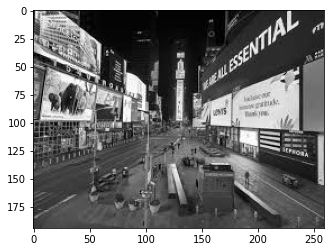

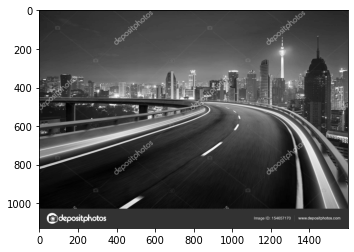

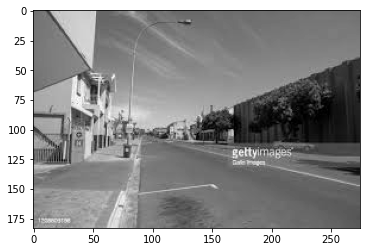

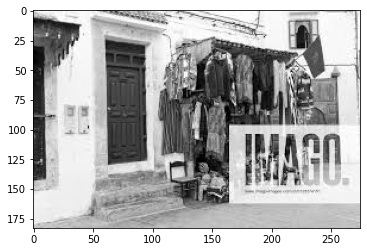

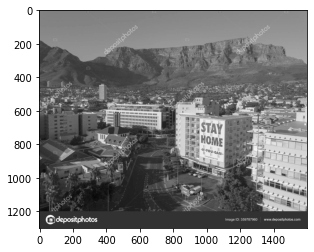

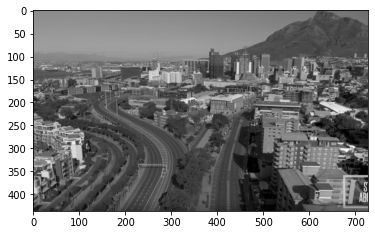

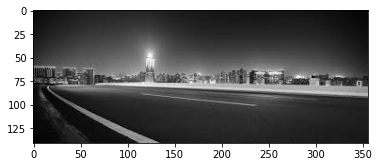

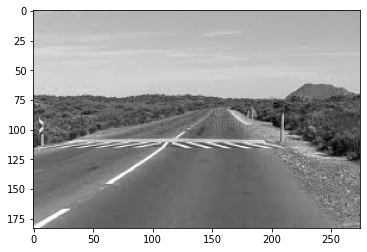

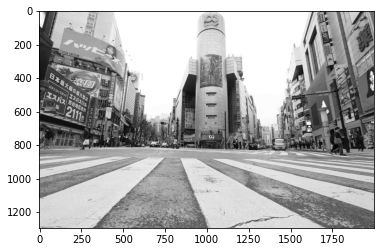

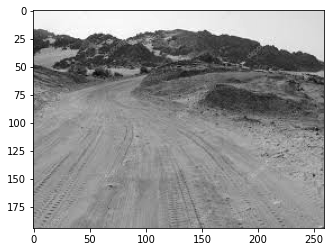

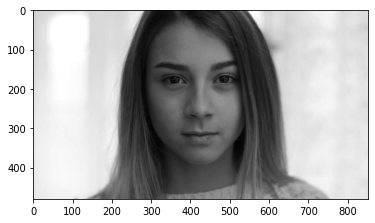

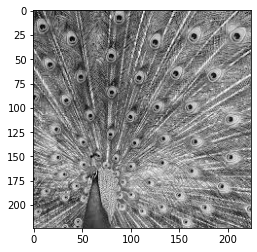

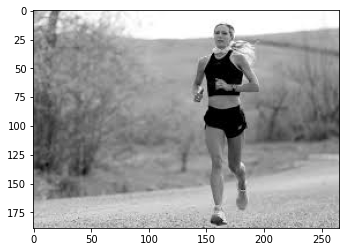

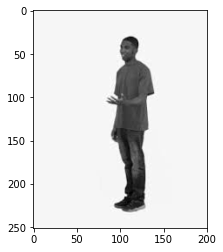

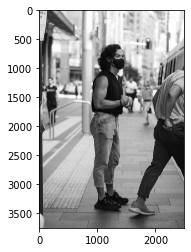

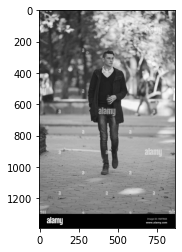

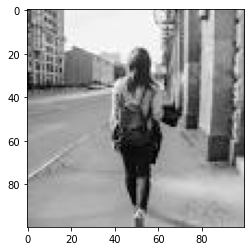

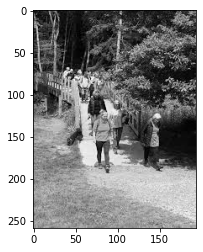

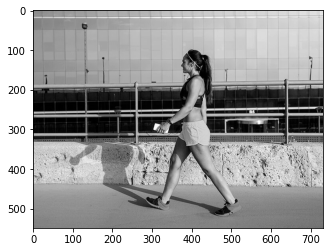

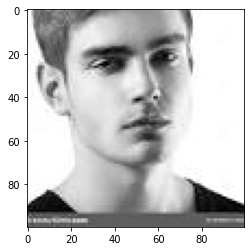

In [4]:
# Access data directory
DATADIR = '/content/People-Street-Data-Image/train'
CATEGORIES = ["street", "people"]
for category in CATEGORIES:  # do street and people 
    path = os.path.join(DATADIR,category)  # create path to street and people (train/street, .. train/people)
    x=0
    for img in os.listdir(path):  # iterate over each image per street and people
        x+=1
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array .. (train/street/1.jpg.., train/people/1.jpg..)
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!
        if x==10 : 
            break        

class_num = CATEGORIES.index(category) # 0,1

# Resize the Training Images to the appropriate size

In [5]:
IMG_SIZE = 100
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do street and person

        path = os.path.join(DATADIR,category)  # create path to street and person
        class_num = CATEGORIES.index(category)  # get the classification  (0 or 1). 0=street 1=person

        for img in tqdm(os.listdir(path)):  # iterate over each image per street and person
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to .. array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data .. size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
           

create_training_data() # call function
print(len(training_data)) 


100%|██████████| 1084/1084 [00:03<00:00, 356.92it/s]

2039


# Shuffle Images to guarantee randomness

In [6]:
random.shuffle(training_data) # Done shuffling
for sample in training_data[:10]: # show first 10
    print(sample[1]) # show the lable

0
1
1
0
0
1
0
1
1
0


# Split data to get the images and labels

In [7]:
# split the array to show image and lables seperatly
X_train = []
y_train = []
for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

print(X_train[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE)

[[[[116]
   [ 98]
   [100]
   ...
   [ 15]
   [ 13]
   [ 19]]

  [[131]
   [108]
   [117]
   ...
   [ 12]
   [ 12]
   [ 20]]

  [[123]
   [128]
   [103]
   ...
   [ 12]
   [ 14]
   [ 20]]

  ...

  [[ 52]
   [ 50]
   [ 46]
   ...
   [ 76]
   [ 81]
   [ 83]]

  [[ 56]
   [ 53]
   [ 51]
   ...
   [100]
   [112]
   [123]]

  [[ 58]
   [ 55]
   [ 52]
   ...
   [ 90]
   [ 83]
   [103]]]]


# Building CNN Schema

In [8]:
# Buillding CNN:
KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)),
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(2,activation='softmax') ,    
        ])



# Run CNN and show summary

In [9]:
# Run CNN:
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# show summary
print('Model Details are : ')
print(KerasModel.summary())


Model Details are : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 200)       2000      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 150)       270150    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 150)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 120)       162120    
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 80)        86480     
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 50)        36050     
                                   

# setup callbacks 

In [10]:
# Set a learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10) # To prevent over fitting we will stop the learning after 10 .. epochs and val_loss value not decreased

# to stop or reduce if near overfiting
callbacks = [earlystop, learning_rate_reduction]

# Split train data to get train and validate data

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)#test_size 20%

# Training CNN

In [12]:
batch_size = 86
epochs = 100

X_train= np.array(X_train)
y_train= np.array(y_train)
X_val= np.array(X_val)
y_val= np.array(y_val)

history = KerasModel.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val),
                         steps_per_epoch=X_train.shape[0] // batch_size,
                         verbose=1, callbacks=callbacks)

Epoch 1/100
18/18 [==============================] - 34s 817ms/step - loss: 1.5576 - accuracy: 0.5015 - val_loss: 0.6735 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 5s 306ms/step - loss: 0.6713 - accuracy: 0.5653 - val_loss: 0.6471 - val_accuracy: 0.5637 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 6s 307ms/step - loss: 0.6373 - accuracy: 0.6168 - val_loss: 0.5921 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 6s 310ms/step - loss: 0.5724 - accuracy: 0.6867 - val_loss: 0.4930 - val_accuracy: 0.8137 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 6s 311ms/step - loss: 0.4668 - accuracy: 0.7811 - val_loss: 0.3841 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 6s 312ms/step - loss: 0.4091 - accuracy: 0.8314 - val_loss: 0.3545 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 6s 324ms/s

# Resize Test Image to the appropriate size

In [13]:
IMG_SIZE = 100
test_data = []

DATADIR = '/content/People-Street-Data-Image/test'

def create_training_data():
    for category in CATEGORIES:  # do street and people

        path = os.path.join(DATADIR,category)  # create path to street and people
        class_num = CATEGORIES.index(category)  # get the classification  (0 or 1). 0=street 1=people

        for img in tqdm(os.listdir(path)):  # iterate over each image per street and people
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to .. array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data .. size
                test_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
           

create_training_data() # call function
print(len(test_data)) 


100%|██████████| 439/439 [00:00<00:00, 747.51it/s]

760


# Shuffle Images to guarantee randomness

In [14]:
random.shuffle(test_data) # Done shuffling
for sample in test_data[:10]: # show first 10
    print(sample[1]) # show the lable

0
0
1
1
0
0
0
0
0
1


# Split data to get the images and labels

In [15]:
# split the array to show image and lables seperatly
X_test = []
y_test = []
for features,label in test_data:
    X_test.append(features)
    y_test.append(label)

print(X_test[0].reshape(-1, IMG_SIZE, IMG_SIZE))
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE)
y_test = np.array(y_test)

[[[ 14  14  14 ...  11  10  10]
  [ 14  14  14 ...  11  10  10]
  [ 14  14  14 ...  11  10  10]
  ...
  [ 98  98  96 ...  46  41  39]
  [128 124 121 ...  41  38  36]
  [ 94  97 101 ...  41  38  36]]]


# Evaluate CNN

In [16]:
test_loss, test_acc = KerasModel.evaluate(X_test ,y_test, verbose=1)
print('Accuracy is: ', test_acc)
print('Loss is: ', test_loss)

24/24 [==============================] - 1s 38ms/step - loss: 0.3651 - accuracy: 0.9145
Accuracy is:  0.9144737124443054
Loss is:  0.36508244276046753


# Predict CNN Output

In [17]:
prediction = KerasModel.predict(X_test)
print(prediction)

[[4.4750751e-04 9.9955243e-01]
 [1.0000000e+00 2.7096632e-11]
 [8.2213346e-06 9.9999177e-01]
 ...
 [9.9999976e-01 2.1238857e-07]
 [5.4826658e-05 9.9994516e-01]
 [9.9999630e-01 3.7218729e-06]]


# Plotting Images along with prediction labels

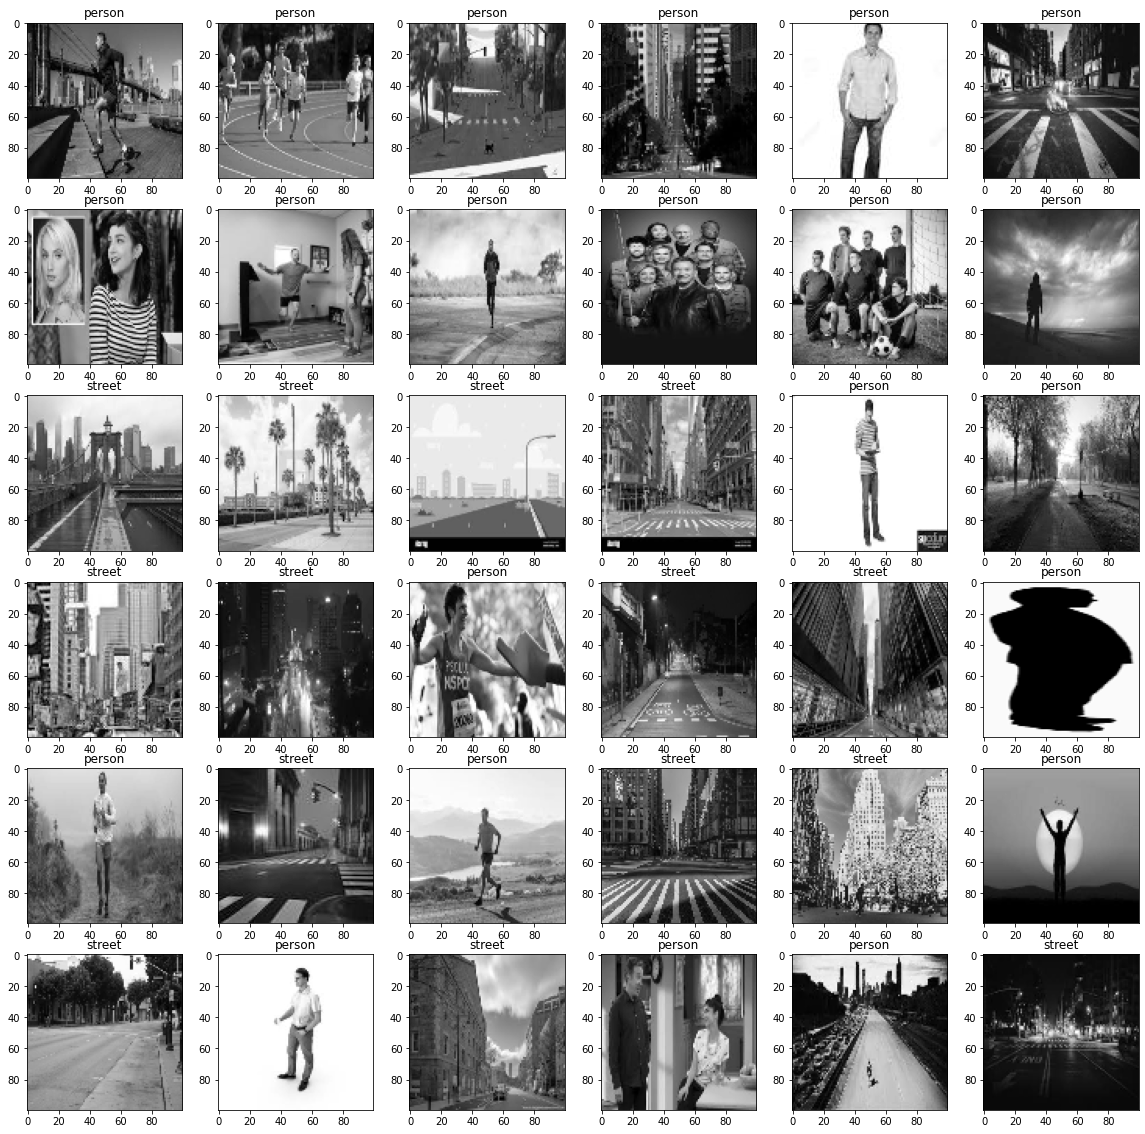

In [18]:
plt.figure(figsize=(20, 20)) 
for n,i in enumerate(list(np.random.randint(0, len(X_test),36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(X_test[i], cmap=plt.cm.gray)
    i = np.argmax(prediction[i])
    if i == 1:
        plt.title('person')
    else:
        plt.title('street')
        